# Testing that Attention is All You Need (To Build a Graph)

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import scipy as sp
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from models.submodels.interaction_gnn import InteractionGNN
from models.submodels.agnn import AGNN
from models.generation_utils import load_dataset

## Roadmap

1. Instantiate an AGNN model
2. Pull up an example graph
3. Run the graph through AGNN and plot the attention weights as color
4. For a particular node, backpropagate the attention weights for N graph iterations
5. Plot the relevance (as function of attention) of that node versus all other nodes for each graph iteration

## Load Trained Model

In [103]:
# load config
with open("toy_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [104]:
# Load trained lightning model from config["artifacts"]
run_id = "1t2740jh"
artifact_dir = os.path.join(config["artifacts"], "LRP_Study_A", run_id, "checkpoints")
# List files in artifact dir
artifact_files = os.listdir(artifact_dir)
artifact_file = artifact_files[-1]
# Load the model
model = AGNN.load_from_checkpoint(os.path.join(artifact_dir, artifact_file))

In [105]:
model.setup(stage="fit")
sample = model.valset[1]

Setting up dataset


## Functions

In [106]:
def get_attention_weights(model, sample):
    with torch.no_grad():
        x = sample.x
        edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
        output, attention_weights = model(x, edges, log_attention=True)
        output = torch.sigmoid(output)
    return output, attention_weights

import matplotlib.cm as cm
def plot_graph_attention(x, edges, weights):
    weights = weights.numpy()
    plt.figure(figsize=(10, 10))
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    for i in range(edges.shape[1]):
        plt.plot([x[edges[0, i], 0], x[edges[1, i], 0]], [x[edges[0, i], 1], x[edges[1, i], 1]], c=cm.inferno(1-weights[i][0]), alpha=weights[i][0])
    plt.scatter(x[:, 0], x[:, 1], s=20)
    plt.show()
    
def get_adjacency_matrices(attention_weights, sample):
    adj_list = []

    for i in range(len(attention_weights)):
        # Turn edges to dense adjacency matrix with entries
        edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
        edges = torch.cat([edges, torch.arange(sample.x.shape[0]).repeat(2, 1)], dim=1)
        adj = torch.zeros(edges.max()+1, edges.max()+1)
        adj[edges[0, :], edges[1, :]] = attention_weights[i].squeeze()
        adj_list.append(adj)

    return adj_list

def get_relevance_matrices(adj_list):

    mult_adj_list = []

    mult_adj_list.append(adj_list[-1])
    # Matrix multiply and normalize along rows
    for i in range(-2, -len(adj_list)-1, -1):
        mult_adj = torch.matmul(adj_list[i], mult_adj_list[-1])
        mult_adj = F.normalize(mult_adj, p=1, dim=0)
        mult_adj_list.append(mult_adj)

    return mult_adj_list

def append_relevant_edges(mult_adj_list, k):

    topk = torch.topk(mult_adj_list[-1], k=k, dim=0)[1]
    attentive_edges = torch.stack([topk, torch.arange(test.shape[1]).repeat(k, 1)], dim=1)

    return attentive_edges

## Inference Run

In [107]:
output, attention_weights = get_attention_weights(model, sample)

<AxesSubplot:ylabel='Count'>

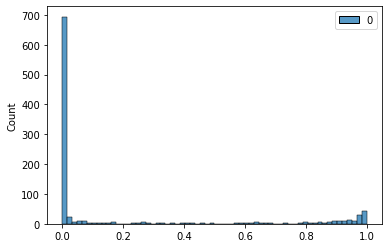

In [108]:
sns.histplot(output.numpy())

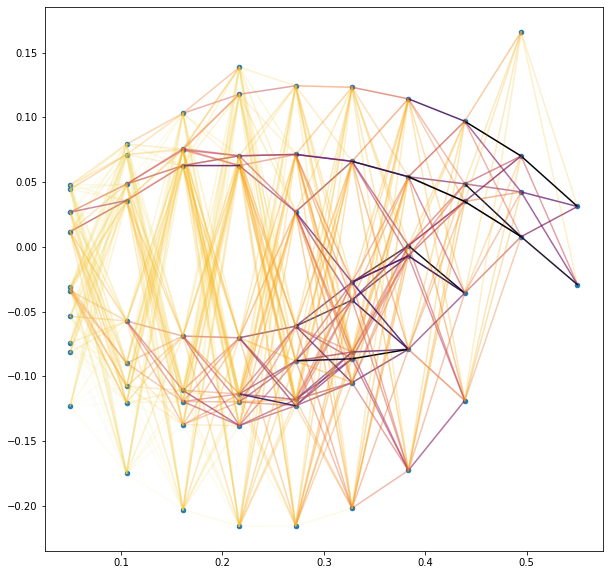

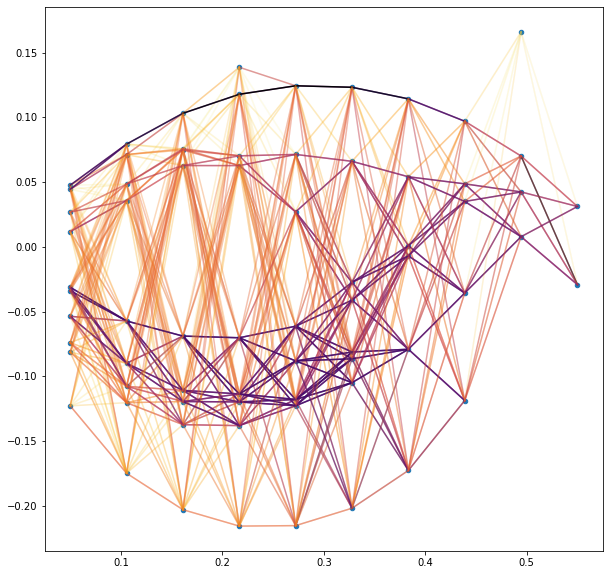

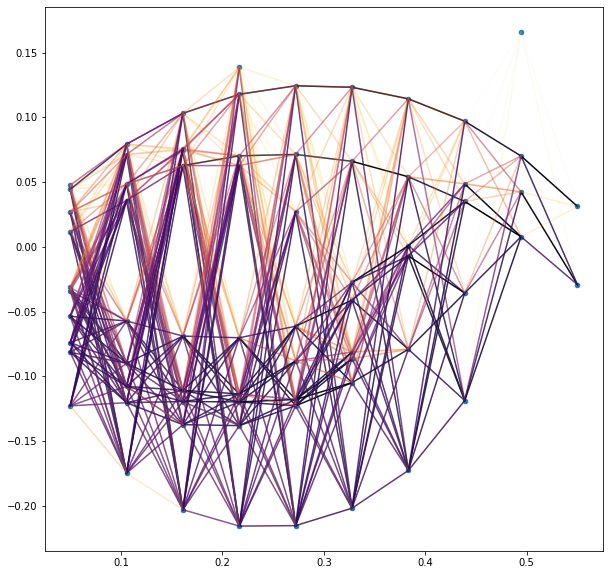

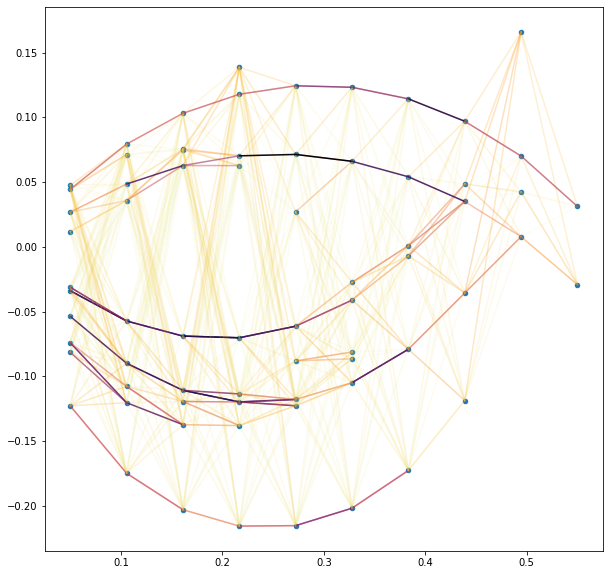

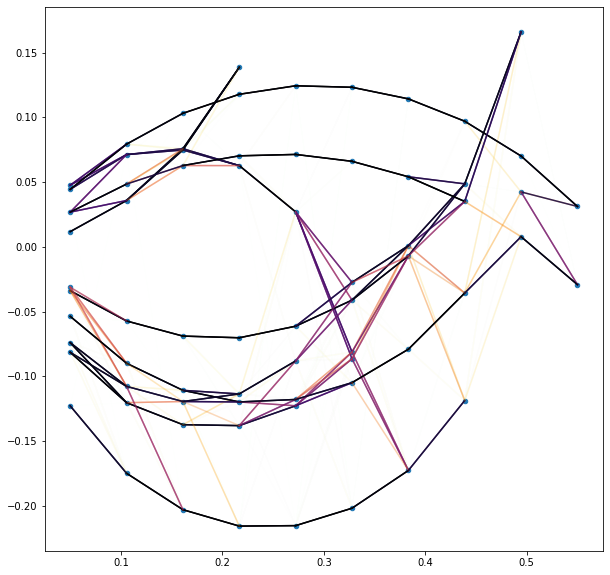

In [109]:
for attention_weight in attention_weights:
    edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
    plot_graph_attention(sample.x, edges, attention_weight)
    plt.pause(0.1)

plot_graph_attention(sample.x, edges, output)

## Apply Attention Propagation

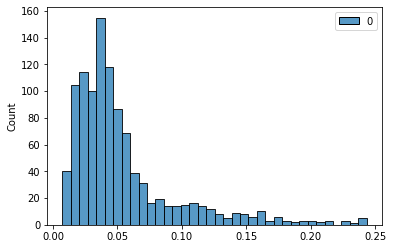

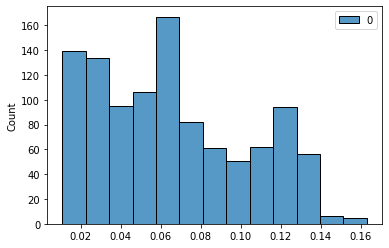

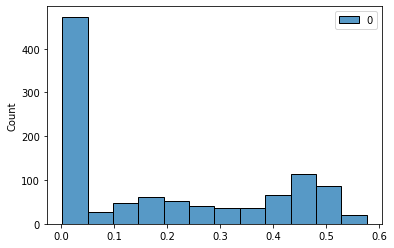

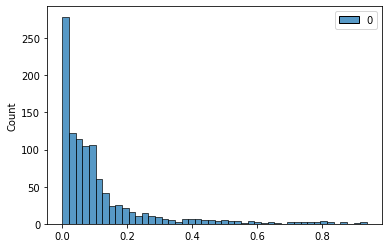

In [110]:
for i in range(len(attention_weights)):
    sns.histplot(attention_weights[i].numpy())
    plt.pause(0.1)

**Approach**

- Initially, just cast the weights to dense adjacency matrix
- Loop through backwards weights, multiplying by the previous attention weights
- Normalize the resulting matrix by summing over the rows
- Repeat for all graph iterations


In [111]:
adj_list = []

for i in range(len(attention_weights)):
    # Turn edges to dense adjacency matrix with entries
    edges = torch.cat([sample.edge_index, sample.edge_index.flip(0)], dim=1)
    edges = torch.cat([edges, torch.arange(sample.x.shape[0]).repeat(2, 1)], dim=1)
    adj = torch.zeros(edges.max()+1, edges.max()+1)
    adj[edges[0, :], edges[1, :]] = attention_weights[i].squeeze()
    adj_list.append(adj)

In [113]:
mult_adj_list = []
mult_adj_list.append(adj_list[-1])
# Matrix multiply and normalize along rows
for i in range(-2, -len(adj_list)-1, -1):
    mult_adj = torch.matmul(adj_list[i], mult_adj_list[-1])
    mult_adj = F.normalize(mult_adj, p=1, dim=0)
    mult_adj_list.append(mult_adj)

In [30]:
mult_adj_list[-1][:, -2]

tensor([0.0060, 0.0477, 0.0086, 0.0290, 0.0026, 0.0056, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0065, 0.0515, 0.0018, 0.0168, 0.0030, 0.0102, 0.0009, 0.0021,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0055, 0.0440, 0.0102, 0.0343, 0.0032,
        0.0062, 0.0058, 0.0465, 0.0081, 0.0276, 0.0024, 0.0052, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0060, 0.0502, 0.0102, 0.0323, 0.0034, 0.0063, 0.0000,
        0.0025, 0.0222, 0.0045, 0.0141, 0.0014, 0.0031, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0069, 0.0516, 0.0109, 0.0328, 0.0032, 0.0054, 0.0000, 0.0000,
        0.0000, 0.0029, 0.0285, 0.0065, 0.0246, 0.0022, 0.0055, 0.0000, 0.0000,
        0.0000, 0.0070, 0.0020, 0.0184, 0.0040, 0.0238, 0.0069, 0.0057, 0.0419,
        0.0097, 0.0272, 0.0016, 0.0023, 0.0000, 0.0000, 0.0023, 0.0017, 0.0156,
        0.0026, 0.0089, 0.0008, 0.0018, 0.0000, 0.0000, 0.0000, 0.0000, 0.0018,
        0.0171, 0.0032, 0.0109, 0.0011, 0.0023, 0.0000, 0.0060, 0.0407, 0.0040])

In [118]:
mult_adj_list = []
mult_adj_list.append(adj_list[-1])
# Matrix multiply and normalize along rows
for i in range(-2, -len(adj_list)-1, -1):
    mult_adj = torch.matmul(adj_list[i], mult_adj_list[-1]) + adj_list[i]
    mult_adj = F.normalize(mult_adj, p=1, dim=0)
    mult_adj_list.append(mult_adj)

In [119]:
def plot_node_relevance(node_of_interest, adj_matrix):
    weights = adj_matrix[:, node_of_interest]
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    weights = weights.numpy()
    plt.figure(figsize=(10, 10))

    true_edges = sample.edge_index[:, sample.y]
    NOI_true_edges = true_edges[:, (sample.pid[true_edges] == sample.pid[node_of_interest]).all(0)]
    plt.plot(sample.x[NOI_true_edges, 0],sample.x[NOI_true_edges, 1], c="green", linewidth=1)

    plt.scatter(sample.x[:, 0], sample.x[:, 1], s=1, c="gray")
    plt.scatter(sample.x[:, 0], sample.x[:, 1], s=weights*100, c=cm.inferno(weights))
    plt.scatter(sample.x[node_of_interest, 0], sample.x[node_of_interest, 1], s=100, c="red", marker="*")

    

<AxesSubplot:ylabel='Count'>

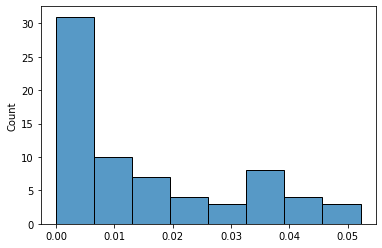

In [123]:
sns.histplot(mult_adj_list[-1][:, 0])

In [125]:
mult_adj_list[-1]

tensor([[0.0522, 0.0421, 0.0059,  ..., 0.0000, 0.0000, 0.0000],
        [0.0397, 0.0431, 0.0149,  ..., 0.0000, 0.0000, 0.0000],
        [0.0337, 0.0426, 0.0510,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0695, 0.0740, 0.0477],
        [0.0000, 0.0000, 0.0000,  ..., 0.1262, 0.0990, 0.1325],
        [0.0000, 0.0000, 0.0000,  ..., 0.0203, 0.1601, 0.1829]])

In [129]:
test = torch.randint(10, (5,5))

In [142]:
k = 2
topk = test.topk(k, dim=0)[1]
attentive_edges = torch.stack([topk, torch.arange(test.shape[1]).repeat(k, 1)], dim=1)

In [143]:
torch.topk(mult_adj_list[-1], k=2, dim=0)[1]

tensor([[ 0, 44, 63,  4, 59, 33,  7,  6, 63,  9,  7, 11, 12, 13, 13, 33, 34, 28,
         29, 13, 14, 32, 21, 34, 68, 25, 28,  7, 28, 13, 14, 13, 14, 32, 33, 69,
          7, 62,  3,  4, 40, 41, 41, 42,  7,  0,  9, 46, 47, 50, 51, 52, 53, 35,
          7, 55, 13, 14, 15, 33,  7, 60,  3, 62, 65, 66, 67, 68, 69, 69],
        [ 7, 46,  3,  3, 22, 31, 18, 62,  3, 48, 61, 62,  3, 29, 14, 31, 59, 55,
         56, 30, 31, 20, 33, 22, 66, 53, 55, 61, 56, 29, 30, 31, 31, 33, 34, 24,
         61,  8, 63, 21, 59, 66, 42, 33, 44, 45, 45, 47, 48, 49, 50, 35, 52, 53,
         61, 12, 56, 31, 57, 23, 60,  2, 61,  4, 63, 64, 65, 52, 53, 68]])

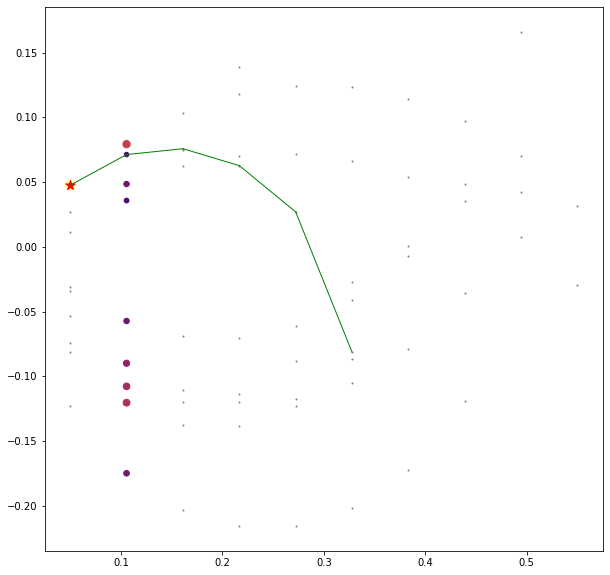

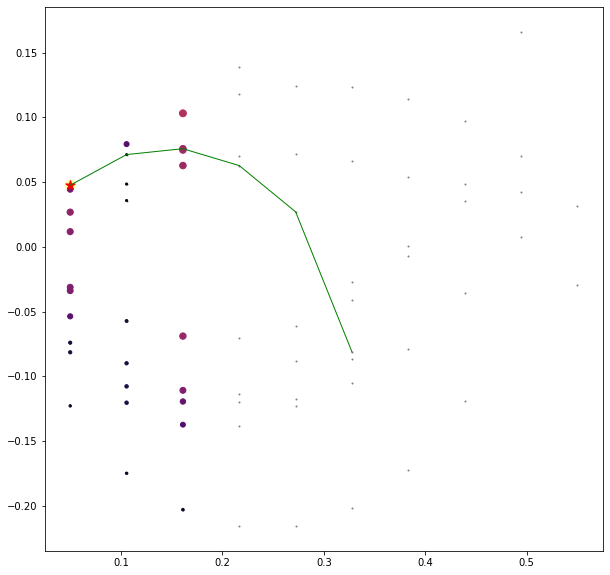

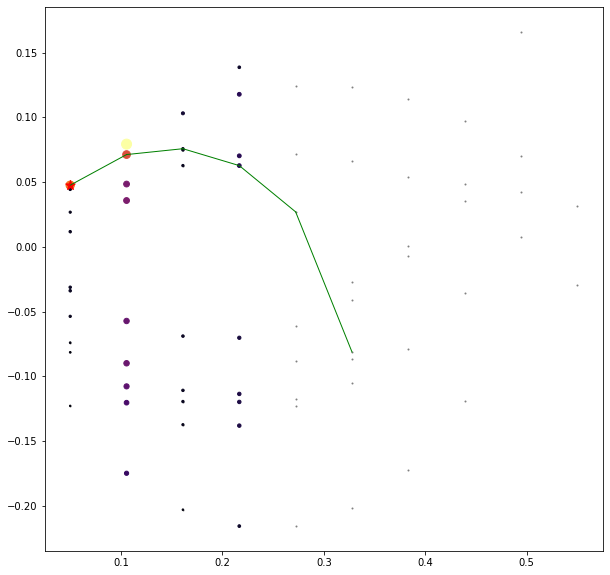

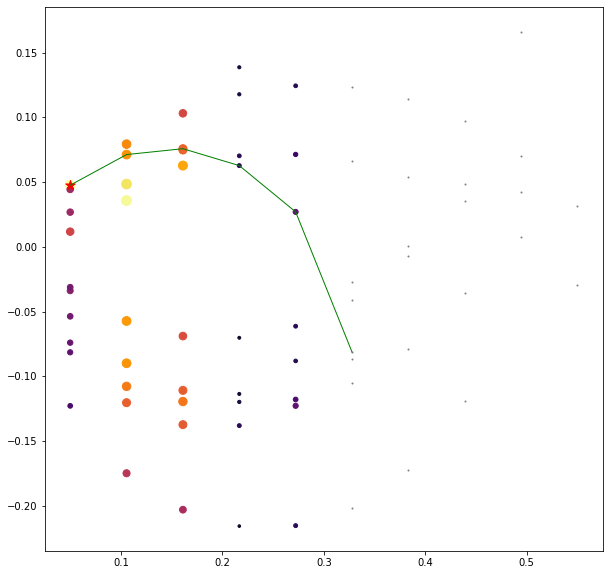

In [144]:
for adj_matrix in mult_adj_list:
    plot_node_relevance(0, adj_matrix)
    plt.pause(0.1)

## Attention-Based Construction

The idea here is that, given a GNN trained on a graph dataset, we rebuild the edges of this datasest according to:
- Which edges pass the output cut (of course)
- Which edges should be constructed from the adjacency matrix

Therefore, need to do the following:
1. Construct an actual dataset that is saved
2. Run the model on the dataset
3. Apply the attention propagation algorithm to the output of the model
4. Construct the new graph from the attention propagation algorithm

### Build Dataset

In [152]:
# load config
with open("toy_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [153]:
from models.generation_utils import generate_toy_event

In [154]:
num_tracks, track_dis_width, num_layers, min_r, max_r, detector_width, ptcut, eff, pur = config["num_tracks"], config["track_dis_width"], config["num_layer"], config["min_r"], config["max_r"], config["detector_width"], config["ptcut"], config["eff"], config["pur"]

In [155]:
save_dir = "/global/cfs/cdirs/m3443/data/TrackLRP/toy_dataset_v1"
subdirs = ["train", "val", "test"]

for i, subdir in enumerate(subdirs):
    if not os.path.exists(os.path.join(save_dir, subdir)):
        os.makedirs(os.path.join(save_dir, subdir))
    
    for j in range(config["datatype_split"][i]):

        data = generate_toy_event(num_tracks, track_dis_width, num_layers, min_r, max_r, detector_width, ptcut, eff, pur)
        torch.save(data, os.path.join(save_dir, subdir, f"{j}"))

### Apply Attention Propagation to Dataset